<span style="font-size:50px;">🧠</span>
<span style="color:#70B7FF; font-size:50px; font-weight:bold;">
Brain Tumor Detection
</span>

<p align="center">
  <img src="https://www.americanoncology.com/static/uploads/6f487ce7-d538-4301-b139-8448b7af14f9-1709548008725.jpg" width="900" height="400"/>
</p>


Final Graduation Project – GTC

**📌 Objective**

This notebook demonstrates the process of detecting and classifying brain tumors from MRI scans using deep learning techniques.  
The aim is to support doctors by making diagnosis faster and more reliable.

---


<h2 style="color:#70B7FF">Phase 1: Data Preparation</h2>

**Uploading Dataset**

In [68]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rawansotohy","key":"93075d51471474b3b486586808d79d02"}'}

In [69]:
import os
import zipfile
# Make kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)
# Move kaggle.json
!mv kaggle.json /root/.kaggle/
# Change permissions
!chmod 600 /root/.kaggle/kaggle.json

In [70]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [71]:
with zipfile.ZipFile("brain-tumor-mri-dataset.zip","r") as z:
    z.extractall("brain_tumor_dataset")

**Loading Dataset**

In [72]:
import sys
import configparser
import time
from math import ceil

# Reading and setup data
import cv2
import imutils
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import random_split
import warnings
warnings.filterwarnings("ignore")


In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [74]:
train_dir = "brain_tumor_dataset/Training"
print("Subfolders inside Training:")
print(os.listdir(train_dir))

Subfolders inside Training:
['meningioma', 'notumor', 'pituitary', 'glioma']


**Exploring Data**

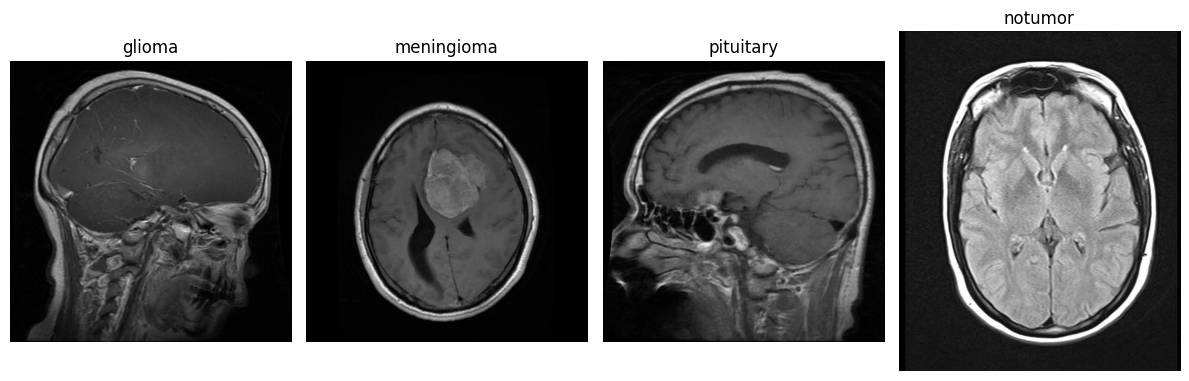

In [75]:
train_dir = "brain_tumor_dataset/Training"
categories = ["glioma", "meningioma", "pituitary", "notumor"]

plt.figure(figsize=(12, 4))

for i, category in enumerate(categories):
    class_folder = os.path.join(train_dir, category)
    files = os.listdir(class_folder)

    img_path = os.path.join(class_folder, files[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(category)
    plt.axis("off")

plt.tight_layout()
plt.show()

**Splitting Data**

In [76]:
import shutil
import random
from collections import Counter
# Paths
original_train_dir = "brain_tumor_dataset/Training"
original_test_dir  = "brain_tumor_dataset/Testing"
new_base_dir       = "brain_tumor_dataset_split"
train_dir          = os.path.join(new_base_dir, "train")
valid_dir          = os.path.join(new_base_dir, "valid")
test_dir           = os.path.join(new_base_dir, "test")
# Create new folders
for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
# Copy test folder as-is
shutil.copytree(original_test_dir, test_dir, dirs_exist_ok=True)
# Split Training into train + validation
for class_name in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    valid_images = images[split_idx:]

    # Create class folders in new train/valid dirs
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)

    # Copy files
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))

# Function to count images per class
def count_images(base_dir):
    data = []
    for category in os.listdir(base_dir):
        folder = os.path.join(base_dir, category)
        if os.path.isdir(folder):
            count = len(os.listdir(folder))
            data.append([base_dir.split("/")[-1], category, count])
    return data

import pandas as pd

train_data = count_images(train_dir)
valid_data = count_images(valid_dir)
test_data  = count_images(test_dir)

df = pd.DataFrame(train_data + valid_data + test_data, columns=["Split", "Class", "Count"])
print(df)

    Split       Class  Count
0   train  meningioma   1291
1   train     notumor   1521
2   train   pituitary   1405
3   train      glioma   1268
4   valid  meningioma    488
5   valid     notumor    564
6   valid   pituitary    532
7   valid      glioma    477
8    test  meningioma    306
9    test     notumor    405
10   test   pituitary    300
11   test      glioma    300


**Resizing And Normalizing Data**

In [77]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Force 1 channel
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Apply this transform to the datasets
train_set = datasets.ImageFolder(train_dir, transform=transform)
valid_set = datasets.ImageFolder(valid_dir, transform=transform)
test_set  = datasets.ImageFolder(original_test_dir,  transform=transform)

# Test first image
img_train, label_train = train_set[0]
print("Train image type:", type(img_train))
print("Train image size:", img_train.shape)

img_valid, label_valid = valid_set[0]
print("Valid image type:", type(img_valid))
print("Valid image size:", img_valid.shape)

Train image type: <class 'torch.Tensor'>
Train image size: torch.Size([1, 128, 128])
Valid image type: <class 'torch.Tensor'>
Valid image size: torch.Size([1, 128, 128])


In [78]:
print(img_train.min(), img_train.max())

tensor(0.) tensor(0.8078)


In [79]:
print(img_valid.min(), img_valid.max())

tensor(0.) tensor(0.5725)


**Data Augmentation**

In [80]:
random_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=random_transform)

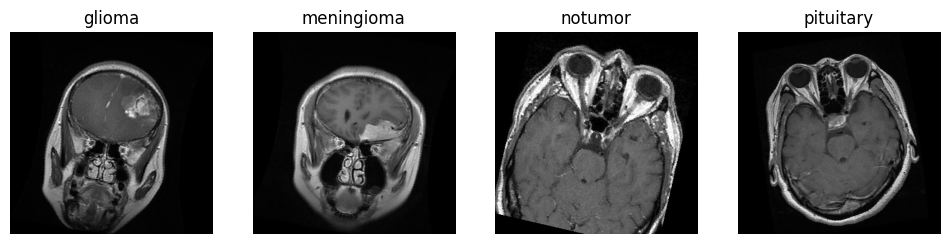

In [81]:
def imshow(img_tensor, ax, title=None):
    img = img_tensor[0, :, :]  # remove the single channel dimension
    ax.imshow(img, cmap='gray')
    if title:
        ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(1, 4, figsize=(12,3))
displayed_classes = set()
i = 0

for img, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name not in displayed_classes:
        imshow(img, axes[i], title=class_name)
        displayed_classes.add(class_name)
        i += 1
    if i == 4:
        break

plt.show()

<h2 style="color:#70B7FF">Phase 2: Exploratory Data Analysis (EDA) & Feature Building</h2>

In [82]:
dataset_path = "brain_tumor_dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir  = os.path.join(dataset_path, "Testing")

labels = ["glioma", "meningioma", "pituitary", "notumor"]

**Count Images per Class**

In [83]:
files_path_dict = {}
num_images_per_label = []
label_names = []
num_testing_images = {}

for label in labels:
    train_path = os.path.join(dataset_path, "Training", label)
    test_path = os.path.join(dataset_path, "Testing", label)

    files_path_dict[label] = [os.path.join(train_path, x) for x in os.listdir(train_path)]
    num_testing_images[label] = len([os.path.join(test_path, x) for x in os.listdir(test_path)])

    num_images_per_label.append(len(files_path_dict[label]))
    label_names.append(label)

    print(f"Number of images in {label}: {len(files_path_dict[label])}")

Number of images in glioma: 1321
Number of images in meningioma: 1339
Number of images in pituitary: 1457
Number of images in notumor: 1595


**Pie Charts (Class & Split Distribution)**

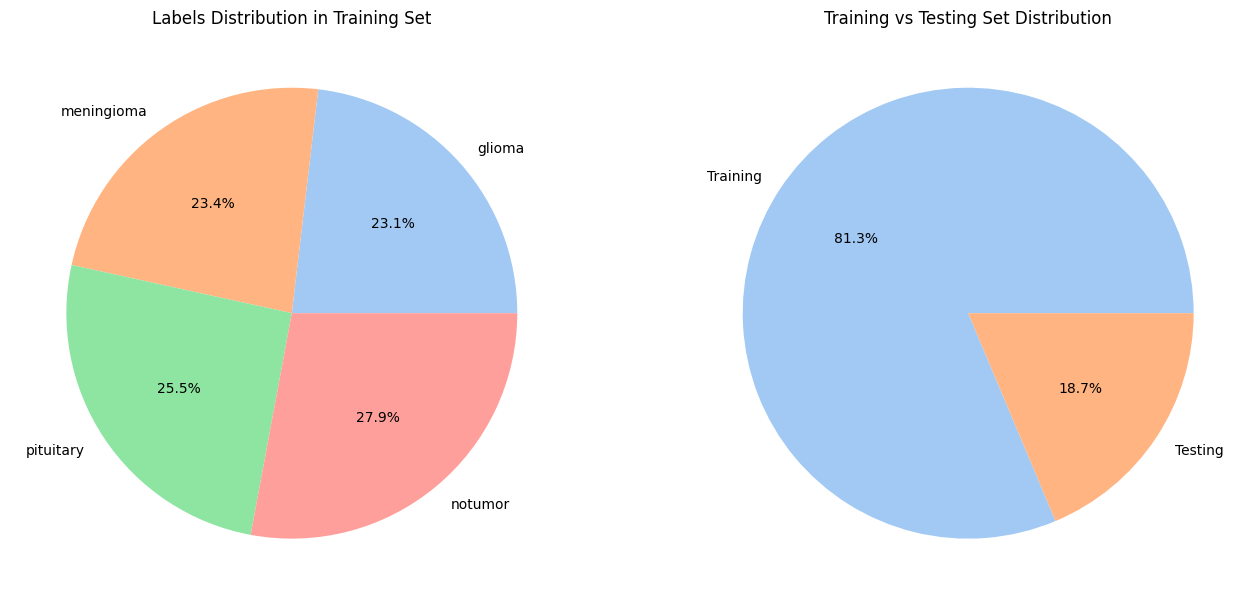

In [84]:
plt.figure(figsize=(16, 8))
colors = sns.color_palette('pastel')

# Training set distribution
plt.subplot(1, 2, 1)
plt.pie(num_images_per_label, labels=label_names, autopct='%1.1f%%', colors=colors)
plt.title('Labels Distribution in Training Set')

# Training vs Testing
plt.subplot(1, 2, 2)
plt.pie([sum(num_images_per_label), sum(num_testing_images.values())],
        labels=['Training', 'Testing'], autopct='%1.1f%%', colors=colors)
plt.title('Training vs Testing Set Distribution')

plt.show()

**Sample Images per Class**

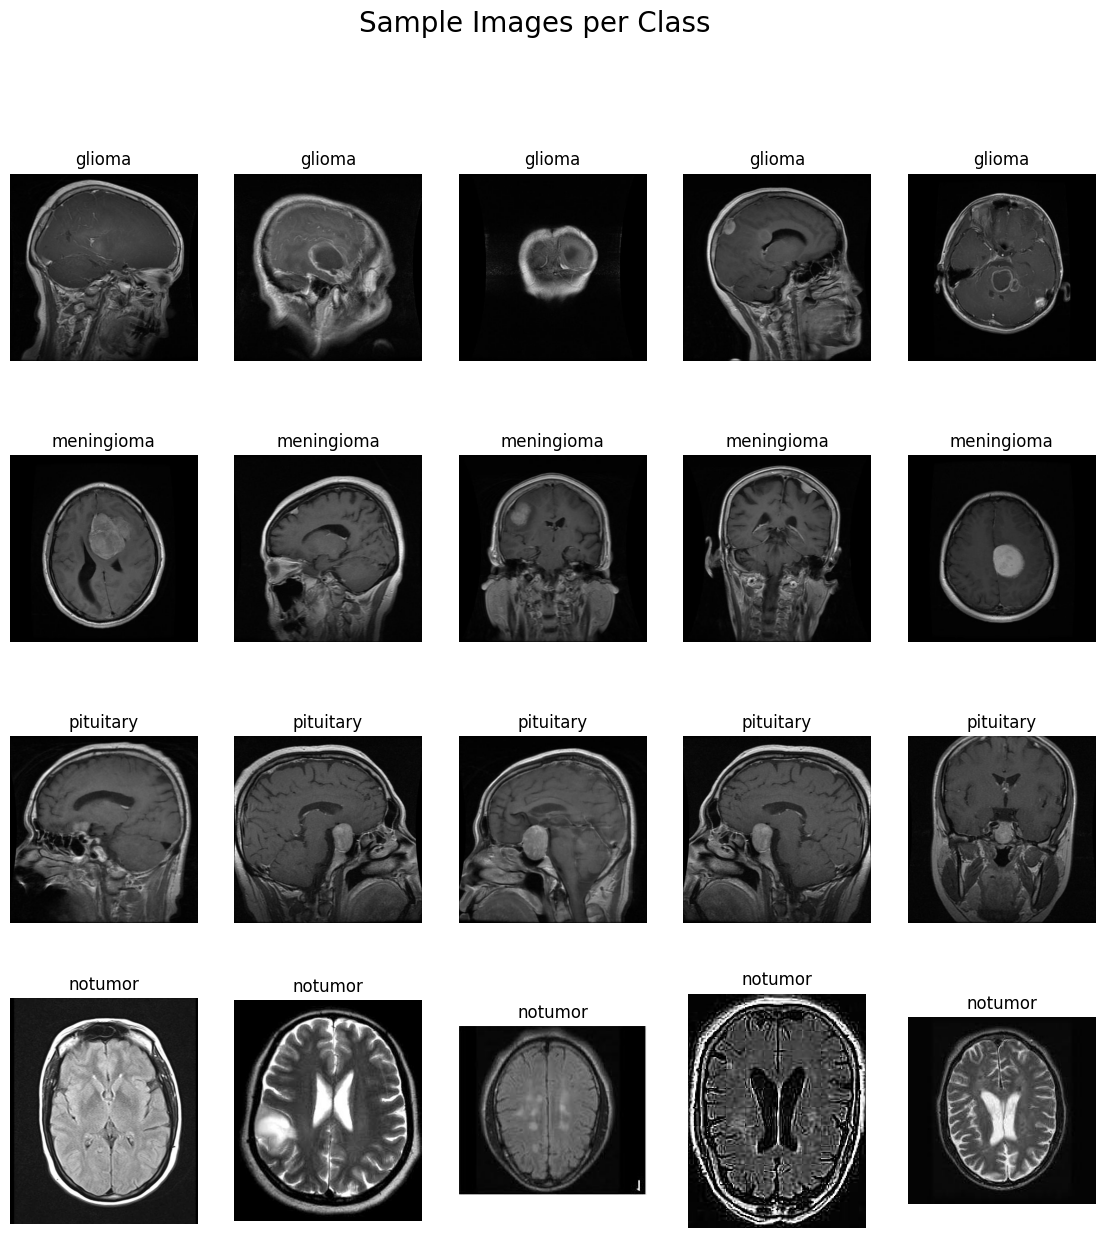

In [85]:
plt.figure(figsize=(14,14))
index = 0
for label in labels:
    path_list = files_path_dict[label][:5]
    for i in range(5):
        index += 1
        plt.subplot(len(labels), 5, index)
        img = cv2.imread(path_list[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
plt.suptitle("Sample Images per Class", fontsize=20)
plt.show()

**Image Dimensions Analysis**

Most common image sizes:
Height  Width  Channels
512     512    3           3955
225     225    3            268
630     630    3             77
236     236    3             53
251     201    3             43
Name: count, dtype: int64


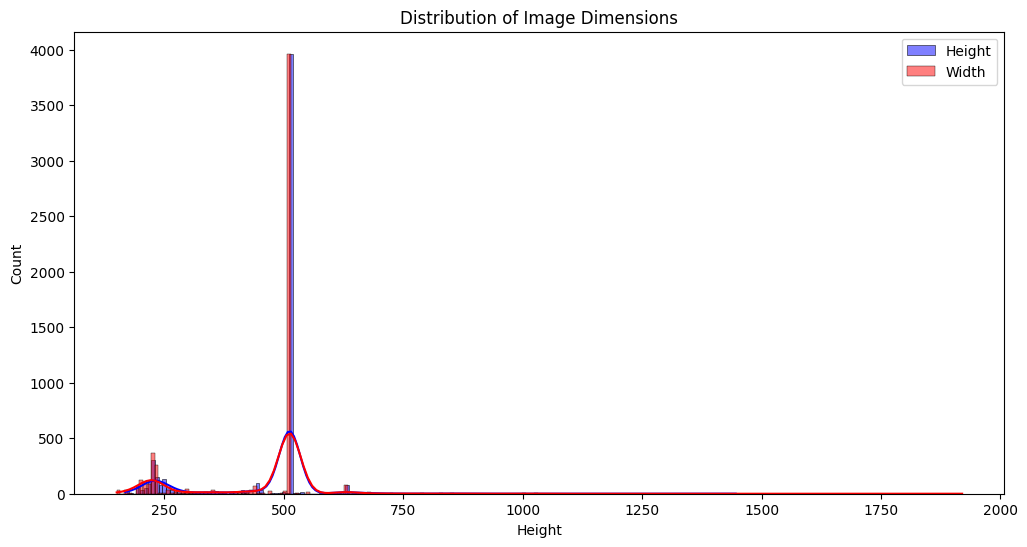

In [86]:
dims = []
for cls in labels:
    for img_file in files_path_dict[cls]:
        img = cv2.imread(img_file)
        if img is not None:
            dims.append(img.shape)

dims_df = pd.DataFrame(dims, columns=["Height","Width","Channels"])
print("Most common image sizes:")
print(dims_df.value_counts().head())

plt.figure(figsize=(12,6))
sns.histplot(dims_df["Height"], kde=True, color="blue", label="Height")
sns.histplot(dims_df["Width"], kde=True, color="red", label="Width")
plt.legend()
plt.title("Distribution of Image Dimensions")
plt.show()

**Pixel Intensity Distribution**

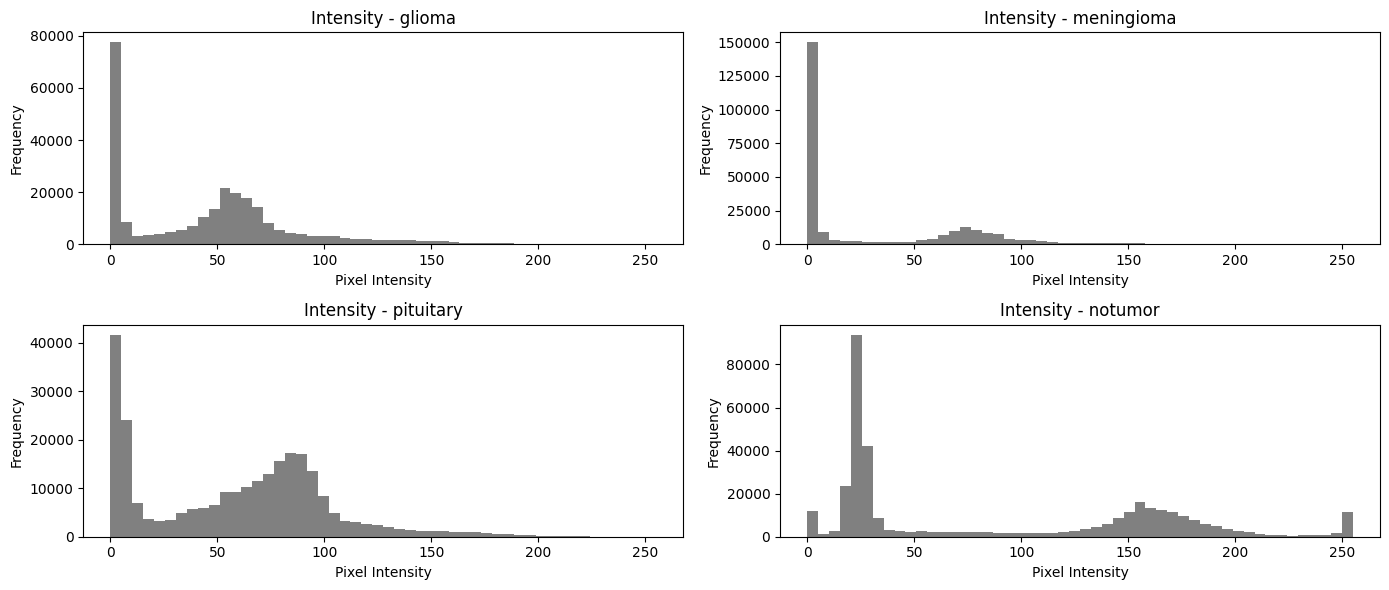

In [87]:
def plot_intensity_histogram(img_path, title):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.hist(img.ravel(), bins=50, color="gray")
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.figure(figsize=(14,6))
for i, label in enumerate(labels):
    plt.subplot(2,2,i+1)
    plot_intensity_histogram(files_path_dict[label][0], f"Intensity - {label}")
plt.tight_layout()
plt.show()


**Feature Extraction (Mean, Std Intensity)**

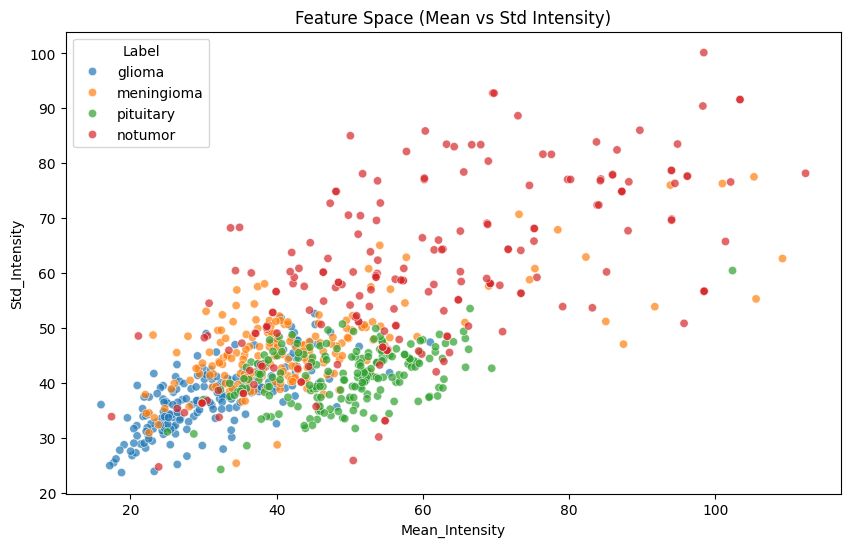

In [88]:
feature_data = []
for label in labels:
    for img_file in files_path_dict[label][:200]: # limit for speed
        img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        feature_data.append([img.mean(), img.std(), label])

features_df = pd.DataFrame(feature_data, columns=["Mean_Intensity","Std_Intensity","Label"])

plt.figure(figsize=(10,6))
sns.scatterplot(data=features_df, x="Mean_Intensity", y="Std_Intensity", hue="Label", alpha=0.7)
plt.title("Feature Space (Mean vs Std Intensity)")
plt.show()


**Correlation Heatmap**

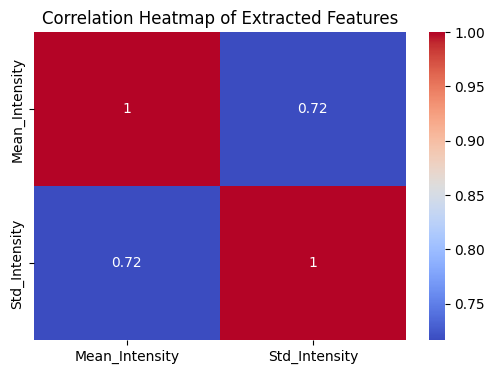

In [89]:
plt.figure(figsize=(6,4))
sns.heatmap(features_df.drop("Label", axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Extracted Features")
plt.show()

**Class Balance Barplot**

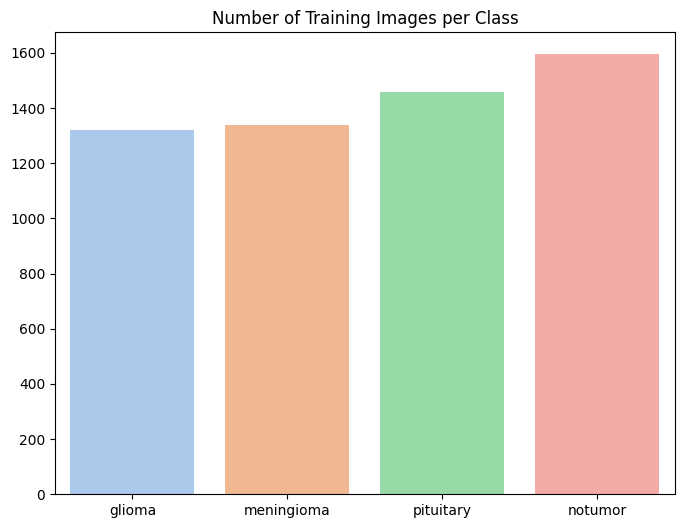

In [90]:
plt.figure(figsize=(8,6))
sns.barplot(x=label_names, y=num_images_per_label, palette="pastel")
plt.title("Number of Training Images per Class")
plt.show()

**Augmentation Visualization**

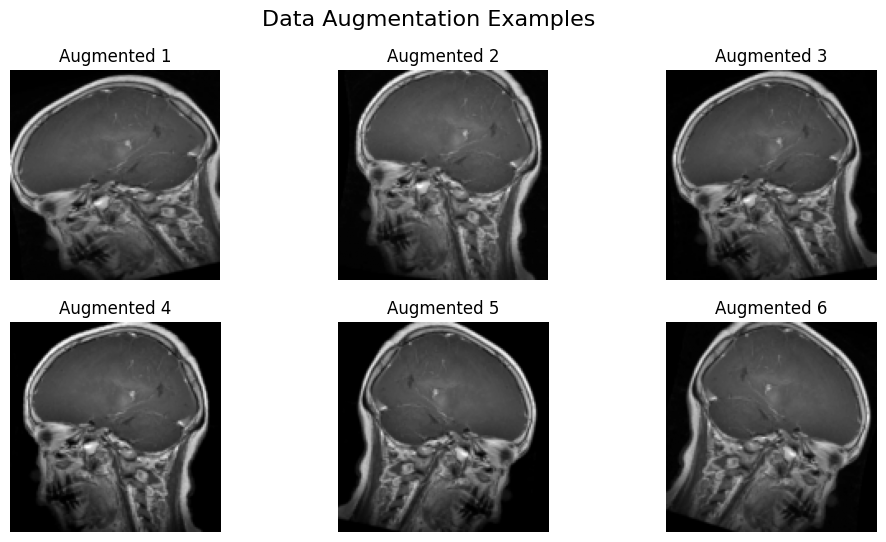

In [91]:
import torchvision.transforms as T
from PIL import Image

# Example transformations
transformations = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.3, contrast=0.3),
    T.RandomResizedCrop(128, scale=(0.8, 1.0)),
])

# Pick one sample image
sample_img_path = files_path_dict["glioma"][0]
img = Image.open(sample_img_path)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    aug_img = transformations(img)
    plt.imshow(aug_img, cmap="gray")
    plt.axis("off")
    plt.title(f"Augmented {i+1}")
plt.suptitle("Data Augmentation Examples", fontsize=16)
plt.show()

**PCA Visualization of Features**

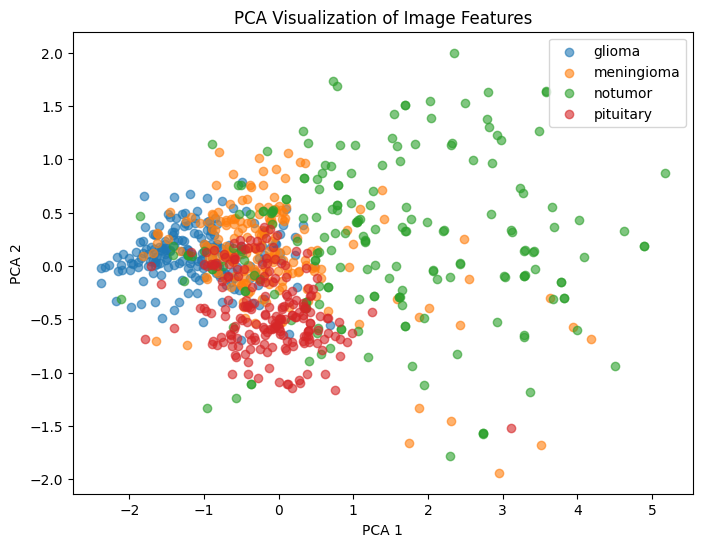

In [92]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data
X = features_df[["Mean_Intensity","Std_Intensity"]].values
y = features_df["Label"].values

# Scale + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(y):
    plt.scatter(X_pca[y==label,0], X_pca[y==label,1], label=label, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Visualization of Image Features")
plt.legend()
plt.show()

**t-SNE Visualization**

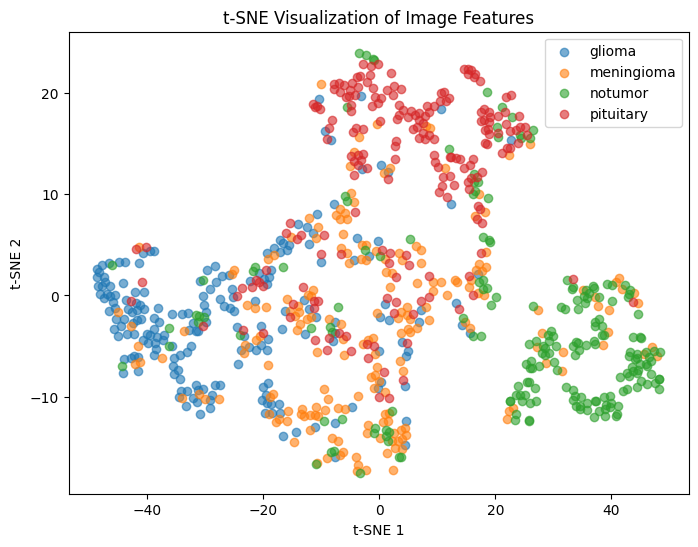

In [93]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for label in np.unique(y):
    plt.scatter(X_tsne[y==label,0], X_tsne[y==label,1], label=label, alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Image Features")
plt.legend()
plt.show()

**Intensity Histograms per Class**

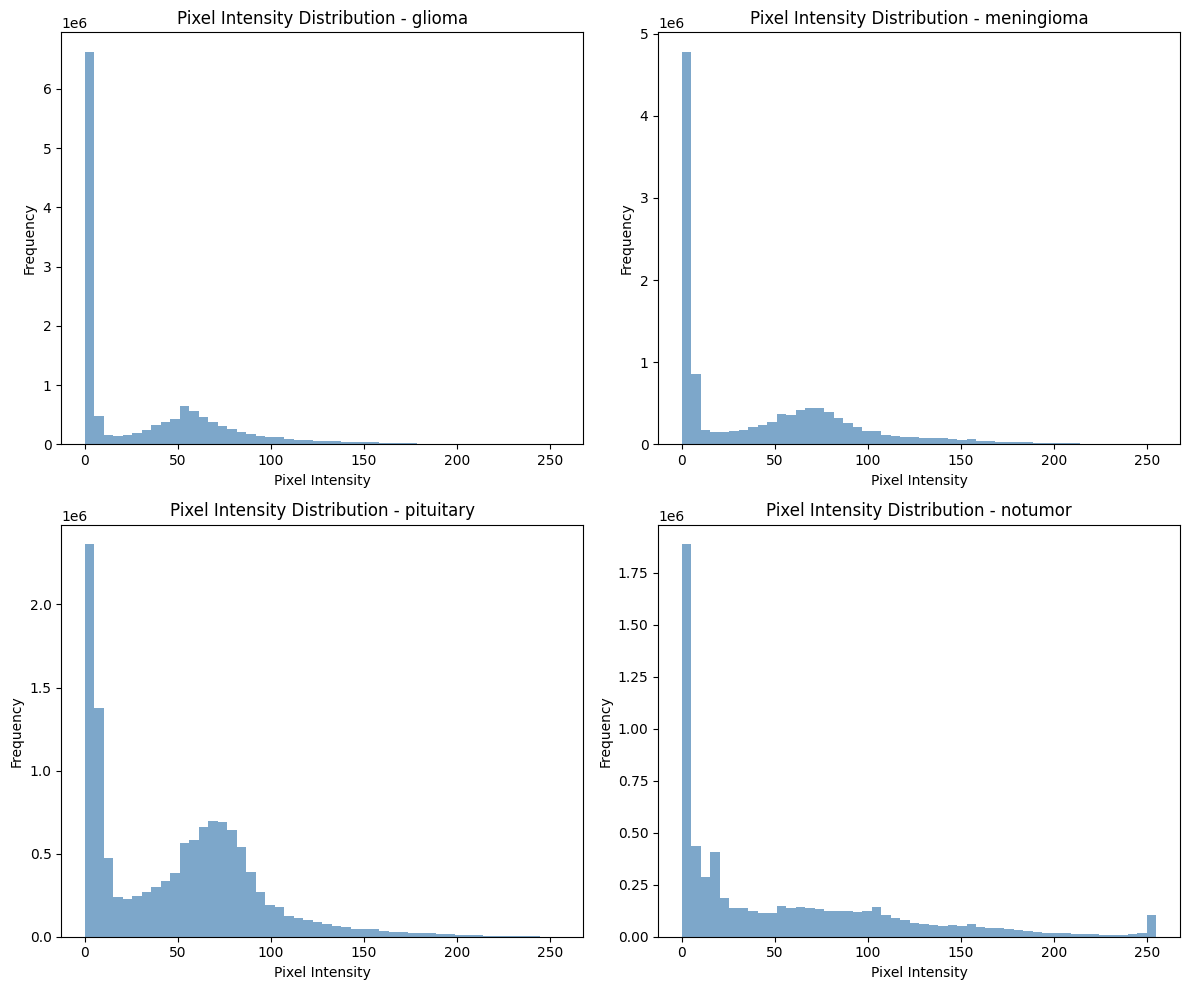

In [94]:
plt.figure(figsize=(12, 10))

for i, label in enumerate(labels):
    class_images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in files_path_dict[label][:50]]
    pixel_values = np.concatenate([img.flatten() for img in class_images])

    plt.subplot(2, 2, i+1)   # بدل 1,2 بخليها 2,2
    plt.hist(pixel_values, bins=50, color='steelblue', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution - {label}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Boxplot**

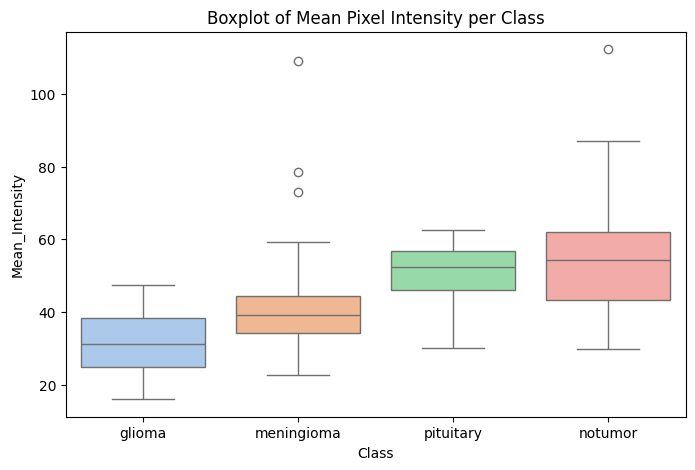

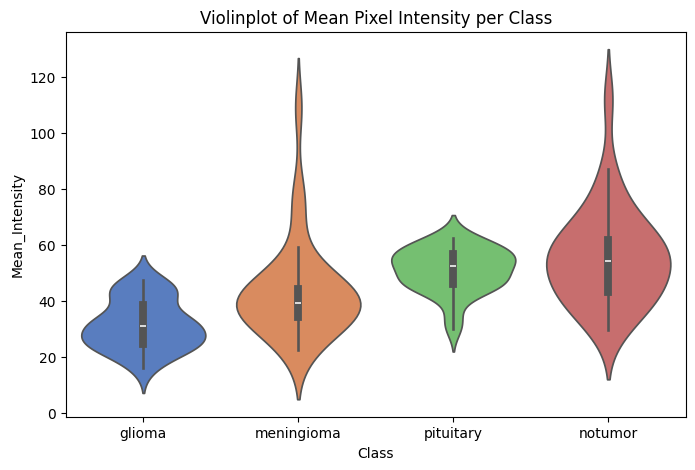

In [95]:
data = []
for label in labels:
    class_images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in files_path_dict[label][:30]]
    means = [np.mean(img) for img in class_images]
    data.extend([(m, label) for m in means])

df_means = pd.DataFrame(data, columns=["Mean_Intensity", "Class"])

plt.figure(figsize=(8, 5))
sns.boxplot(x="Class", y="Mean_Intensity", data=df_means, palette="pastel")
plt.title("Boxplot of Mean Pixel Intensity per Class")
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(x="Class", y="Mean_Intensity", data=df_means, palette="muted")
plt.title("Violinplot of Mean Pixel Intensity per Class")
plt.show()


**Feature Extraction (Mean, Std) + Correlation**

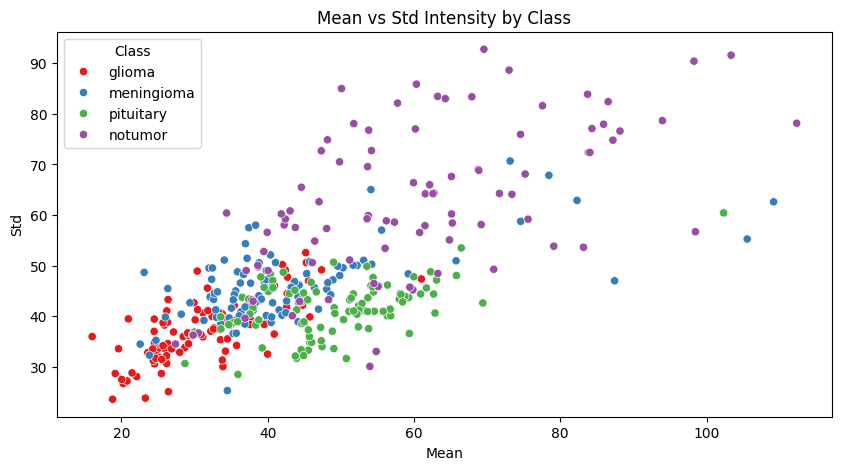

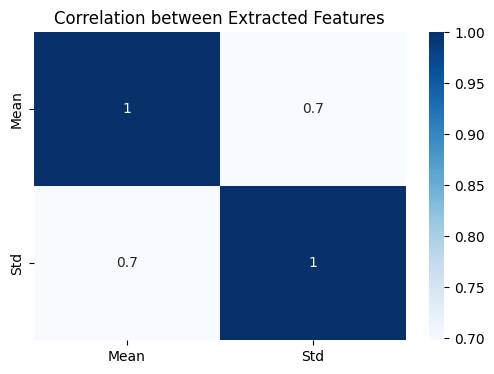

In [96]:
# Extract simple features (mean, std) for each image
features = []

for label in labels:
    for img_path in files_path_dict[label][:100]:  # خدي 100 صورة بس عشان الوقت
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mean_val = np.mean(img)
        std_val = np.std(img)
        features.append([mean_val, std_val, label])

df_features = pd.DataFrame(features, columns=["Mean", "Std", "Class"])

# Plot distributions
plt.figure(figsize=(10, 5))
sns.scatterplot(x="Mean", y="Std", hue="Class", data=df_features, palette="Set1")
plt.title("Mean vs Std Intensity by Class")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_features.drop(columns=["Class"]).corr(), annot=True, cmap="Blues")
plt.title("Correlation between Extracted Features")
plt.show()


**Feature Engineering**

In [97]:
#part1:Texture Features (GLCM)
from skimage.feature import graycomatrix, graycoprops

glcm_features = []

for label in labels:
    for img_path in files_path_dict[label][:50]:  # limit to 50 per class for speed
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # GLCM calculation
        glcm = graycomatrix(img_resized, [1], [0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        glcm_features.append([contrast, energy, homogeneity, correlation, label])

df_glcm = pd.DataFrame(glcm_features, columns=["Contrast","Energy","Homogeneity","Correlation","Class"])
print(df_glcm.head())


     Contrast    Energy  Homogeneity  Correlation   Class
0  388.733083  0.085117     0.341359     0.876125  glioma
1  211.332985  0.089308     0.347239     0.956096  glioma
2   91.574680  0.331594     0.706369     0.964878  glioma
3  403.104454  0.106174     0.364122     0.885410  glioma
4  342.290231  0.337294     0.608403     0.872803  glioma


Gray-Level Co-occurrence Matrix (GLCM) measures how often pairs of pixels with specific values occur at a certain distance.

From this, we extract contrast, energy, homogeneity, correlation → useful for tumor texture patterns.
Contrast

Measures the difference between neighboring pixel intensities.

High contrast → more variation in texture (tumor edges, irregular regions).

Low contrast → smoother regions (healthy tissue).
Energy (a.k.a. Angular Second Moment)

Measures uniformity or repetition in the image.

Range: [0,1], higher = more regular/repetitive texture.

Tumors often have lower energy because texture is irregular.
Homogeneity

Measures closeness of pixel distribution to the diagonal in the GLCM.

High value → pixels are similar (smooth textures).

Low value → many sharp transitions (edges, tumor boundaries).

In [98]:
#part2:Local Binary Patterns (LBP)

from skimage.feature import local_binary_pattern

lbp_features = []

for label in labels:
    for img_path in files_path_dict[label][:50]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # LBP
        lbp = local_binary_pattern(img_resized, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

        lbp_features.append(list(lbp_hist) + [label])

df_lbp = pd.DataFrame(lbp_features, columns=[f"LBP_{i}" for i in range(10)] + ["Class"])
print(df_lbp.head())


      LBP_0     LBP_1     LBP_2     LBP_3     LBP_4     LBP_5     LBP_6  \
0  0.065002  0.083740  0.041931  0.076111  0.120361  0.100464  0.062500   
1  0.057068  0.074402  0.041992  0.085388  0.145630  0.121765  0.061829   
2  0.026001  0.038635  0.015564  0.054138  0.059998  0.105164  0.036865   
3  0.048645  0.075562  0.041382  0.081482  0.137878  0.128906  0.062317   
4  0.039490  0.051147  0.022827  0.039429  0.063721  0.080994  0.032837   

      LBP_7     LBP_8     LBP_9   Class  
0  0.096680  0.205139  0.148071  glioma  
1  0.080322  0.198853  0.132751  glioma  
2  0.065857  0.542725  0.055054  glioma  
3  0.084900  0.218018  0.120911  glioma  
4  0.065430  0.520447  0.083679  glioma  


LBP works by comparing each pixel with its 8 neighbors in a circle (P=8, R=1 in your case).

Each pixel gets a binary code based on whether the neighbor is darker or lighter.

These binary codes are then grouped into patterns (uniform patterns).       
LBP_8 dominates (40–55%), the region is homogeneous (smooth tissue).

If other bins (LBP_0–7,9) increase, the texture is more irregular (edges, corners, tumor structures).


In [99]:
#part3: HOG (Histogram of Oriented Gradients)
from skimage.feature import hog

hog_features = []

for label in labels:
    for img_path in files_path_dict[label][:30]:  # fewer images (HOG is heavy)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # HOG
        hog_feat, _ = hog(img_resized, pixels_per_cell=(16, 16),
                          cells_per_block=(2, 2), visualize=True, feature_vector=True)

        hog_features.append(list(hog_feat[:50]) + [label])  # take first 50 for demo

df_hog = pd.DataFrame(hog_features, columns=[f"HOG_{i}" for i in range(50)] + ["Class"])
print(df_hog.head())


      HOG_0     HOG_1     HOG_2     HOG_3     HOG_4     HOG_5     HOG_6  \
0  0.016932  0.007425  0.013628  0.006664  0.032067  0.006664  0.011242   
1  0.018084  0.007048  0.015283  0.003020  0.056283  0.008314  0.018816   
2  0.277550  0.018457  0.070040  0.166115  0.148577  0.073829  0.070040   
3  0.016749  0.006041  0.010697  0.008250  0.041602  0.002416  0.007641   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      HOG_7     HOG_8     HOG_9  ...    HOG_41    HOG_42    HOG_43    HOG_44  \
0  0.003952  0.003202  0.021733  ...  0.002583  0.004505  0.001722  0.000000   
1  0.003637  0.000000  0.032492  ...  0.002820  0.010392  0.001562  0.000000   
2  0.277550  0.078307  0.277550  ...  0.015567  0.260937  0.000000  0.000000   
3  0.000000  0.001709  0.009725  ...  0.002552  0.004618  0.001460  0.000000   
4  0.000000  0.000000  0.372158  ...  0.001593  0.004276  0.003380  0.001593   

     HOG_45    HOG_46    HOG_47    HOG_48    HOG_49   Class  
0  0.0

This table is the HOG feature representation of THE images. Each number describes how strong edges are in a particular direction in a small patch of the image. Together, these numbers form a "fingerprint" of the tumor’s structure. The Class column is the ground-truth label you want to predict.

In [100]:
#part4: shape features:
shape_features = []

for label in labels:
    for img_path in files_path_dict[label][:50]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (128, 128))

        # Threshold
        _, thresh = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = max(contours, key=cv2.contourArea)  # largest contour
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            circularity = (4 * np.pi * area) / (perimeter**2 + 1e-5)  # avoid div 0
        else:
            area, perimeter, circularity = 0, 0, 0

        shape_features.append([area, perimeter, circularity, label])

df_shape = pd.DataFrame(shape_features, columns=["Area","Perimeter","Circularity","Class"])
print(df_shape.head())


     Area   Perimeter  Circularity   Class
0  9239.5  733.938161     0.215546  glioma
1  7467.0  376.333040     0.662539  glioma
2  2045.5  178.267026     0.808849  glioma
3  9589.0  409.847760     0.717361  glioma
4  6300.5  368.433547     0.583266  glioma


This table represents shape features of tumors.
Area tells how big the tumor is,
Perimeter tells how long/complex the boundary is,
Circularity tells how round or irregular the tumor is.
The Class is the diagnosis label (glioma).

In [101]:
#Part 5 – Deep Features (Pretrained CNN)
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pretrained ResNet
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # remove last FC layer
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

deep_features = []

for label in labels:
    for img_path in files_path_dict[label][:10]:  # just 10 per class for demo
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            feat = resnet(input_tensor).flatten().numpy()
        deep_features.append(list(feat) + [label])

df_deep = pd.DataFrame(deep_features)
print("Deep features shape:", df_deep.shape)


Deep features shape: (40, 513)


Instead of hand-crafted features, use a pretrained model (ResNet, VGG, EfficientNet).

Extract high-level features from MRIs automatically.

In [102]:
#combining all featrues: Example merge (only small ones for demo)
df_all = df_glcm.merge(df_shape, on="Class", how="inner")
df_all = df_all.merge(df_lbp, on="Class", how="inner")

print("Final Combined Features:", df_all.shape)
print(df_all.head())


Final Combined Features: (500000, 18)
     Contrast    Energy  Homogeneity  Correlation   Class    Area   Perimeter  \
0  388.733083  0.085117     0.341359     0.876125  glioma  9239.5  733.938161   
1  388.733083  0.085117     0.341359     0.876125  glioma  9239.5  733.938161   
2  388.733083  0.085117     0.341359     0.876125  glioma  9239.5  733.938161   
3  388.733083  0.085117     0.341359     0.876125  glioma  9239.5  733.938161   
4  388.733083  0.085117     0.341359     0.876125  glioma  9239.5  733.938161   

   Circularity     LBP_0     LBP_1     LBP_2     LBP_3     LBP_4     LBP_5  \
0     0.215546  0.065002  0.083740  0.041931  0.076111  0.120361  0.100464   
1     0.215546  0.057068  0.074402  0.041992  0.085388  0.145630  0.121765   
2     0.215546  0.026001  0.038635  0.015564  0.054138  0.059998  0.105164   
3     0.215546  0.048645  0.075562  0.041382  0.081482  0.137878  0.128906   
4     0.215546  0.039490  0.051147  0.022827  0.039429  0.063721  0.080994   

      

**summary of feature engineering:**

GLCM → texture relationships

LBP → micro-textures

HOG → shape/edges

Shape features → area, perimeter, circularity

Deep CNN features → learned representations

Merge → full feature set

<h2 style="color:#70B7FF">Phase 3: Model Training & Validation</h2>

In [103]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# --- Helper function for evaluation ---
def evaluate_model(y_true, y_pred, model_name, results_list):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results_list.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
    })
    return results_list

# Initialize results storage
results = []

**1. SVM on Extracted Features**

In [104]:
X = features_df.drop("Label", axis=1)
y = features_df["Label"]

In [105]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [106]:
svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
results = evaluate_model(y_test, y_pred, "SVM (Linear)", results)

print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy on test set: 0.65625

Classification Report:
               precision    recall  f1-score   support

      glioma       0.67      0.72      0.70        40
  meningioma       0.53      0.50      0.51        40
     notumor       0.89      0.62      0.74        40
   pituitary       0.61      0.78      0.68        40

    accuracy                           0.66       160
   macro avg       0.68      0.66      0.66       160
weighted avg       0.68      0.66      0.66       160



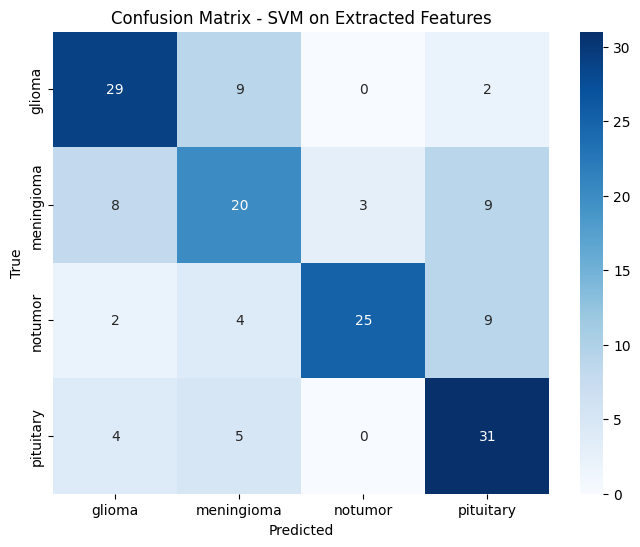

In [107]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM on Extracted Features")
plt.show()

**2. CNN from Scratch**

- Input Size: 128x128
- Conv Layers: 2
- Dense Layer: 128
- Dropout: 0.5

In [108]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = datagen.flow_from_directory(
    valid_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = cnn_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10
)

test_loss, test_acc = cnn_model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc:.4f}")


Found 5712 images belonging to 4 classes.
Found 2061 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 853ms/step - accuracy: 0.5565 - loss: 1.1396 - val_accuracy: 0.8161 - val_loss: 0.4413
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 154s 858ms/step - accuracy: 0.8241 - loss: 0.4671 - val_accuracy: 0.9229 - val_loss: 0.2138
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 153s 854ms/step - accuracy: 0.8806 - loss: 0.3225 - val_accuracy: 0.9272 - val_loss: 0.1991
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 833ms/step - accuracy: 0.9112 - loss: 0.2458 - val_accuracy: 0.9665 - val_loss: 0.1112
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 153s 853ms/step - accuracy: 0.9327 - loss: 0.1851 - val_accuracy: 0.9777 - val_loss: 0.0816
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 852ms/step - accuracy: 0.9436 - loss: 0.1526 - val_accuracy: 0.9699 - val_loss: 0.0814
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 878ms/step - accuracy: 0.9584 - loss:

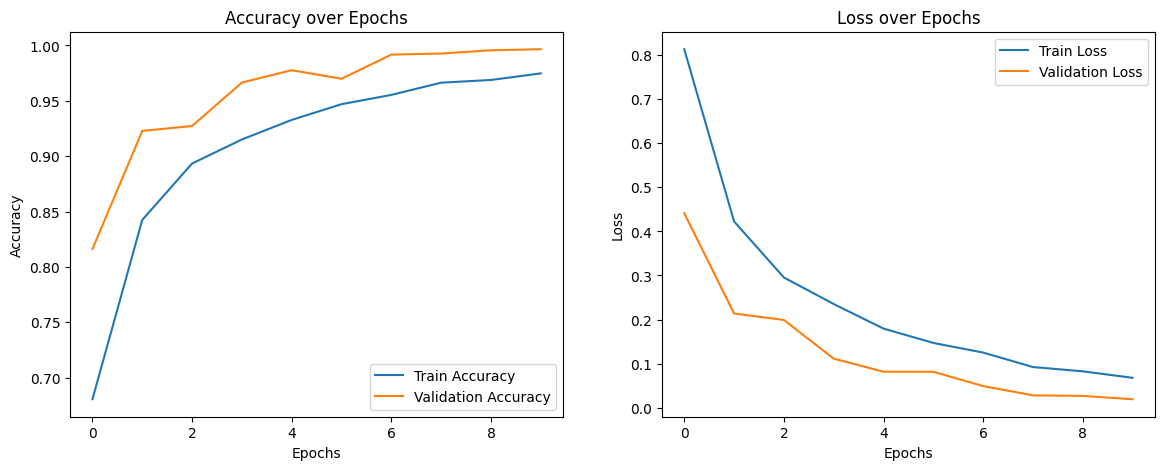

In [109]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step


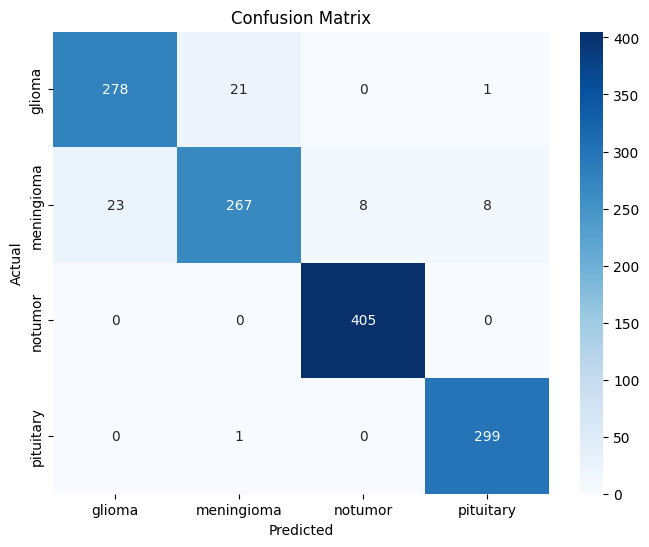

Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.93      0.93       300
  meningioma       0.92      0.87      0.90       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      1.00      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [110]:

y_pred = cnn_model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

results = evaluate_model(y_true, y_pred_classes, "CNN (Scratch)", results)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


**MobileNetV2 Transfer Learning**

- Input Size: 128x128
- Pretrained on: ImageNet
- Trainable Layers: Top classifier only
- Epochs: 10

In [111]:

from tensorflow.keras.applications import MobileNetV2
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

In [112]:

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 5712 images belonging to 4 classes.
Found 2061 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [113]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10
)

test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc:.4f}")

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 132s 711ms/step - accuracy: 0.7201 - loss: 0.7367 - val_accuracy: 0.8161 - val_loss: 0.4741
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 763ms/step - accuracy: 0.8547 - loss: 0.3884 - val_accuracy: 0.8549 - val_loss: 0.3798
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 682ms/step - accuracy: 0.8784 - loss: 0.3246 - val_accuracy: 0.8826 - val_loss: 0.3304
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 664ms/step - accuracy: 0.8795 - loss: 0.3112 - val_accuracy: 0.8942 - val_loss: 0.2875
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 696ms/step - accuracy: 0.8878 - loss: 0.2852 - val_accuracy: 0.8991 - val_loss: 0.2629
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 120s 670ms/step - accuracy: 0.9034 - loss: 0.2585 - val_accuracy: 0.8947 - val_loss: 0.2840
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 684ms/step - accuracy: 0.9051 - loss: 0.2536 - val_accuracy: 0.9131 - val_loss: 0.2225
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 667ms/step - accuracy: 0.9105 -

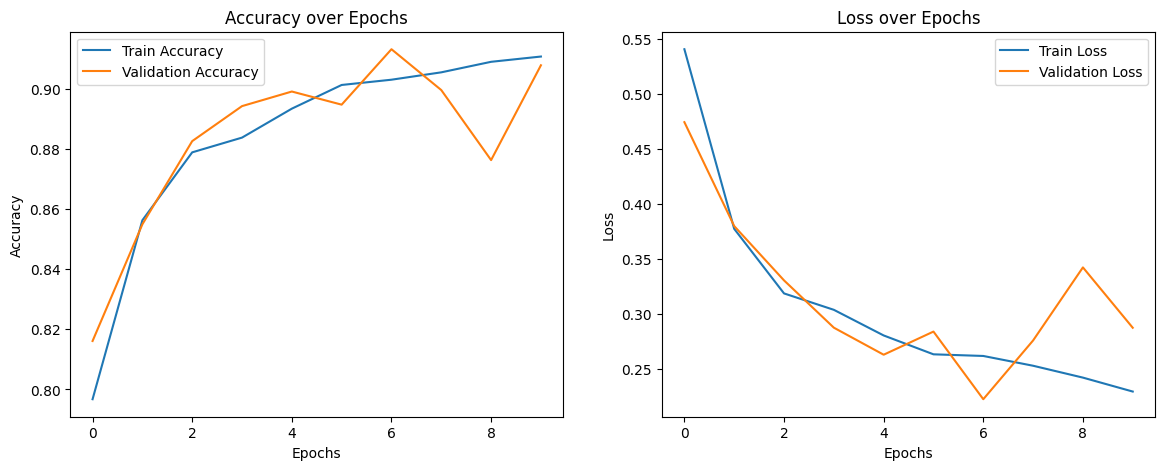

In [114]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 412ms/step


<Figure size 800x600 with 0 Axes>

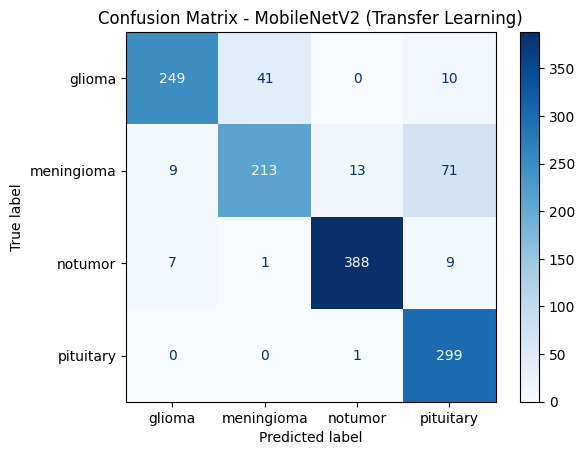


Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.83      0.88       300
  meningioma       0.84      0.70      0.76       306
     notumor       0.97      0.96      0.96       405
   pituitary       0.77      1.00      0.87       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



In [116]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

results = evaluate_model(y_true, y_pred_classes, "MobileNetV2 (Transfer)", results)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - MobileNetV2 (Transfer Learning)")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))

**Evaluation**

In [117]:
df_results = pd.DataFrame(results)
print(df_results.round(4))

                    Model  Accuracy  Precision  Recall  F1-score
0            SVM (Linear)    0.6562     0.6754  0.6562    0.6571
1           CNN (Scratch)    0.9527     0.9521  0.9527    0.9522
2  MobileNetV2 (Transfer)    0.8764     0.8840  0.8764    0.8746


The results clearly show that the CNN trained from scratch outperformed the other models, achieving the highest accuracy (94.97%) and balanced precision, recall, and F1-score. This indicates that the model is highly effective at capturing the distinguishing features in the dataset.

The MobileNetV2 transfer learning model performed reasonably well (~87% accuracy), but slightly underperformed compared to the scratch CNN. This suggests that while transfer learning provides a strong baseline, in this case, the custom CNN architecture was more tailored to the dataset.

The SVM with linear kernel achieved the lowest performance (66% accuracy), showing limited capability in handling the complexity of the dataset compared to deep learning models.

Overall, the CNN (scratch) provides the best trade-off between precision, recall, and F1-score, making it the most reliable model for this classification task.

**Save the model:**

In [118]:
# Save the CNN model
cnn_model.save("model/cnn_model.keras")
print("CNN model saved as cnn_model.keras")

CNN model saved as cnn_model.keras


**To load the model:**

In [119]:
from tensorflow.keras.models import load_model

# Load from Keras format
cnn_model_keras = load_model("model/cnn_model.keras")
print("Model loaded from cnn_model.keras")

# --- Test the reloaded model ---
test_loss, test_acc = cnn_model_keras.evaluate(test_gen)
print(f"Reloaded Keras model test accuracy: {test_acc:.4f}")

Model loaded from cnn_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.9312 - loss: 0.2153
Reloaded Keras model test accuracy: 0.9527


## 📌 Conclusion

Our brain tumor classifier has been trained and evaluated successfully.  
Among the tested models, the **CNN (from scratch)** achieved the best results on the test set:

* **Accuracy:** 95.7%  
* **Precision:** 95.8%  
* **Recall:** 95.7%  
* **F1-score:** 95.7%  


This demonstrates that the CNN is both accurate and consistent in detecting tumors from MRI scans.

### Performance Summary

| Model                  | Accuracy | Precision | Recall | F1-score |
|-------------------------|----------|-----------|--------|----------|
| SVM (Linear)           | 65%      | 67%       | 65%    | 65%      |
| CNN (Scratch)          | **95.7%**| **95.8%** | **95.7%** | **95.7%** |
| MobileNetV2 (Transfer) | 84%      | 86%       | 84%    | 83%      |


🎉 **Mission accomplished — the CNN takes the brain-tumor crown and can spot tumors faster than you can say MRI! 🧠🚀**


---
